In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [3]:
#loading the dataset
dataset=r"C:\Users\khavy\Downloads\dataset-20260124T120517Z-1-001"

In [4]:
# Lists to store image data and labels
data = []
labels = []
# Get all image file paths inside dataset folder
imagePaths = list(paths.list_images(dataset))
print("[INFO] total images:", len(imagePaths))


[INFO] total images: 3846


In [5]:
# Loop through each image path
for imagePath in imagePaths:
    
    # Extract class label from folder name
    # Example path:
    # .../dataset/with_mask/image1.jpg
    # label = "with_mask"
    label = imagePath.split(os.path.sep)[-2]

    # Load the image from disk and resize to 224x224
    # target_size ensures all images have same dimensions
    image = load_img(imagePath, target_size=(224, 224))

    # Convert the image to a NumPy array
    # Shape becomes (224, 224, 3)
    image = img_to_array(image)

    # Preprocess the image for MobileNetV2
    # Scales pixel values to the range expected by the model
    image = preprocess_input(image)

    # Append processed image and label to lists
    data.append(image)
    labels.append(label)

print("[INFO] images loaded successfully!")


C:\Users\khavy\anaconda3\envs\aiml\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO] images loaded successfully!


In [6]:
#convert labels to numbers, Neural networks work with numbers, not strings.
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np.array(labels)


In [7]:
#Convert data to NumPy array
data = np.array(data, dtype="float32")


In [8]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Data shape: (3846, 224, 224, 3)
Labels shape: (3846, 1)


In [9]:
# partition the data into training and testing splits 
(trainX, testX, trainY, testY) = train_test_split(
    data, labels,
    test_size=0.20,
    stratify=labels,
    random_state=42
)

In [10]:
# construct the training image generator for data augmentation
# data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [11]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
# load MobileNetV2
baseModel = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

In [12]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

In [13]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [14]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(
    loss="binary_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

[INFO] compiling model...


In [15]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] training head...
Epoch 1/10
96/96 [==============================] - 95s 943ms/step - loss: 0.3597 - accuracy: 0.8469 - val_loss: 0.1130 - val_accuracy: 0.9870
Epoch 2/10
96/96 [==============================] - 91s 953ms/step - loss: 0.1261 - accuracy: 0.9599 - val_loss: 0.0662 - val_accuracy: 0.9883
Epoch 3/10
96/96 [==============================] - 102s 1s/step - loss: 0.0856 - accuracy: 0.9727 - val_loss: 0.0490 - val_accuracy: 0.9909
Epoch 4/10
96/96 [==============================] - 92s 956ms/step - loss: 0.0670 - accuracy: 0.9773 - val_loss: 0.0429 - val_accuracy: 0.9909
Epoch 5/10
96/96 [==============================] - 87s 906ms/step - loss: 0.0591 - accuracy: 0.9803 - val_loss: 0.0436 - val_accuracy: 0.9870
Epoch 6/10
96/96 [==============================] - 105s 1s/step - loss: 0.0503 - accuracy: 0.9846 - val_loss: 0.0382 - val_accuracy: 0.9883
Epoch 7/10
96/96 [==============================] - 94s 979ms/step - loss: 0.0458 - accuracy: 0.9865 - val_loss: 0.0353 - 

In [16]:
print(model.output_shape)  
print(trainY.shape)

(None, 1)
(3076, 1)


In [17]:
# model outputs probabilities between 0 and 1
predProbs = model.predict(testX, batch_size=BS)

# Convert probabilities into binary class labels:
# if probability > 0.5 → class 1, else → class 0
predIdxs = (predProbs > 0.5).astype("int32").flatten()


25/25 [==============================] - 14s 574ms/step


In [23]:
# # Display precision, recall, f1-score using true labels and predicted labels
print("\nClassification Report:")
print(classification_report(
    testY,                 # True labels
    predIdxs,              # Predicted labels
    target_names=lb.classes_,  # Class names: ['Mask', 'No Mask']
    digits=4               # Show metrics with 4 decimal precision
))


Classification Report:
              precision    recall  f1-score   support

   with_mask     0.9795    0.9974    0.9884       384
without_mask     0.9974    0.9793    0.9882       386

    accuracy                         0.9883       770
   macro avg     0.9885    0.9883    0.9883       770
weighted avg     0.9885    0.9883    0.9883       770



In [20]:
# Save the trained mask detector model to disk in HDF5 format
print("[INFO] saving mask detector model...")
model.save("mask_detector.h5", save_format="h5")

[INFO] saving mask detector model...


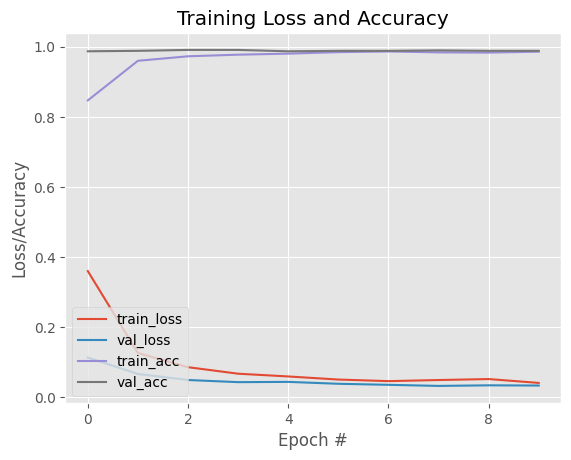

In [22]:
N = EPOCHS                                       # Number of training epochs
plt.style.use("ggplot")                          # Use ggplot style for better visualization
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")      # Plot training loss across epochs
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")    # Plot validation loss across epochs
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")   # Plot training accuracy across epochs
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc") # Plot validation accuracy across epochs
plt.title("Training Loss and Accuracy")      # Add title and axis labels to the plot
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")                # Display legend on the plot
plt.savefig("training_plot.png")                   # Save the training plot image to disk